**About** : This notebook is used to train models.

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/workspace/kaggle_islr/src


## Initialization

### Imports

In [4]:
import os
import torch

print(torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = torch.cuda.get_device_name(0)
print(device)

1.14.0a0+410ce96
Tesla V100-SXM2-32GB-LS


In [5]:
import os
import sys
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import *
from numerize.numerize import numerize

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [6]:
from training.main import k_fold

from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    init_neptune
)

from params import *
from utils.plots import *
from data.dataset import *
from data.preparation import *
from utils.torch import init_distributed, count_parameters, load_model_weights
from utils.plots import plot_sample, plot_sample_with_edges
from model_zoo.models import *

from data.transforms import flip

2023-04-27 13:47:06.236254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [7]:
df = prepare_data(DATA_PATH, processed_folder="torch_12/")
# df = prepare_data(DATA_PATH, processed_folder="torch_3/")

In [8]:
# df = df[df['participant_id'] == 29302].reset_index(drop=True)
# df = df[df['sign'] == "person"].reset_index(drop=True)

In [9]:
dataset = SignDataset(df, max_len=None, train=True, aug_strength=3)
# dataset.fill_buffer(tqdm_enabled=True)

  0%|          | 0/94477 [00:00<?, ?it/s]

1000035562 blow


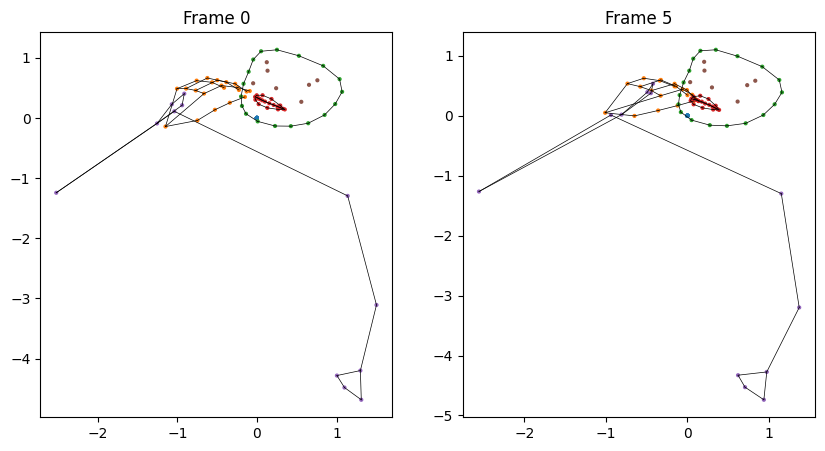

  0%|          | 0/94477 [00:00<?, ?it/s]


In [10]:
for i in tqdm(range(len(dataset))):
    data, dd, d = dataset[i]
    
    print(df['sequence_id'][i], df['sign'][i])
    plot_sample_with_edges(data, n_frames=2, figsize=(10, 5), show_text=False)

    break

In [12]:
# plot_sample_with_edges(data, n_frames=1, figsize=(10, 10), show_text=True, graph=edges)

## Model

In [80]:
model = define_model("mlp_bert_3", transfo_heads=16, embed_dim=16, dense_dim=192, transfo_dim=512 + 128, transfo_layers=3, n_landmarks=100, max_len=25, drop_rate=0.05)

In [81]:
# model = define_model("mlp_bert_3", transfo_heads=16, embed_dim=16, dense_dim=256, transfo_dim=512 + 128, transfo_layers=3, n_landmarks=100, max_len=25)  #, pretrained_weights="../logs/pretrain/2023-03-23/4/mlp_bert_0.pt").cpu()

In [82]:
# load_model_weights(model, "../logs/2023-04-17/18/mlp_bert_3_0.pt")

In [83]:
numerize(count_parameters(model))

'7.69M'

In [49]:
(
    numerize(count_parameters(model.frame_transformer_1)),
    numerize(count_parameters(model.frame_transformer_2)) if model.frame_transformer_2 else 0,
    numerize(count_parameters(model.frame_transformer_3)) if model.frame_transformer_3 else 0
)

('1.74M', '3.59M', '3.39M')

In [ ]:
dataset = SignDataset(df, max_len=25, train=False)

BS = 8

x = {}
batch = [dataset[idx][0] for idx in range(BS)]  # 
# batch = [dataset[idx] for idx in np.random.randint(len(dataset), size=BS)]
for k in data:
    x[k] = torch.cat([d[k].unsqueeze(0) for d in batch])  # .cuda()

In [ ]:
y, y_aux = model(x)
y.size(), y.max()

In [ ]:
# opt = torch.optim.Adam(model.parameters())
# loss = y.mean()
# loss.backward()
# opt.step()
# for name, param in model.named_parameters():
#     if param.grad is None:
#         print(name)
    
# opt.zero_grad()

## Training

In [ ]:
class Config:
    """
    Parameters used for training
    """

    # General
    seed = 42
    verbose = 1
    device = "cuda"
    save_weights = True

    # Data
    processed_folder = "torch_12/"
    max_len = 25
    resize_mode = "pad"
    aug_strength = 3
    use_extra_data = False
    n_landmarks = 100

    # k-fold
    k = 4
    folds_file = f"../input/folds_{k}.csv"
    selected_folds = [0]  # , 1, 2, 3]

    # Model
    #     name = "gcn"
    name = "mlp_bert_3"
    #     name = "bi_bert"
    pretrained_weights = None  # "../logs/pretrain/2023-04-08/2/mlp_bert_3_0.pt"
    syncbn = False
    num_classes = 250
    num_classes_aux = 0

    transfo_layers = 3
    embed_dim = 16
    dense_dim = 256
    transfo_dim = 1024  # 288
    transfo_heads = 16
    drop_rate = 0.05

    # Training
    loss_config = {
        "name": "ce",  # ce
        "smoothing": 0.3,
        "activation": "softmax",
        "aux_loss_weight": 0.0,
        "activation_aux": "softmax",
        "ousm_k": 3,
    }

    data_config = {
        "batch_size": 32,
        "val_bs": 1024,
        "use_len_sampler": False,
    }

    optimizer_config = {
        "name": "AdamW",
        "lr": 3e-4,
        "warmup_prop": 0.1,
        "betas": (0.9, 0.999),
        "max_grad_norm": 10.0,
    }

    epochs = 5

    use_fp16 = True
    model_soup = False

    verbose = 1
    verbose_eval = 250

    fullfit = len(selected_folds) == 4
    n_fullfit = 1

In [ ]:
DEBUG = True
log_folder = None
run = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")
#     run = init_neptune(Config, log_folder)

df = prepare_data(DATA_PATH, Config.processed_folder)
init_distributed(Config)

preds = k_fold(Config, df, log_folder=log_folder, run=run)

Done ! 